In [1]:
from pathlib import Path
import numpy as np

from my_types import Vec3, Quat, ScalarBatch
from my_types import as_vec3, as_scalar_batch
from io_csv import load_gyro_base, load_ref, load_acc, load_mag
from pipelines import integrate_gyro_acc_mag
from evaluation import calc_angle_err, print_err_status, save_err_csv,plot_err_from_csv, save_estimated_vec3_csv
from evaluation import evaluate_estimated_vec3_autosign
import lib_quat as libq

EPS: float = 1e-9

In [2]:
root: Path = Path.cwd().parent
run_dir: Path = root / "data" / "21:08_oct_07_2025_5min"

ori_path: Path = run_dir / "Orientation.csv"
gyro_path: Path = run_dir / "Gyroscope.csv"
grav_path: Path = run_dir / "Gravity.csv"
acc_path: Path = run_dir / "AccelerometerUncalibrated.csv"
acc_lin_path: Path = run_dir / "Accelerometer.csv"
mag_path: Path = run_dir / "Magnetometer.csv"

for p in [ori_path, gyro_path, grav_path, acc_path, acc_lin_path, mag_path]:
        if not p.exists():
                raise FileNotFoundError(f"File not found: {p}")

In [3]:
t_src_gyro, w_src_gyro, dt, t_new, w_avg_gyro = load_gyro_base(gyro_path)

q_ref_interp = load_ref(ori_path, t_new)
q_ref_interp /= np.linalg.norm(q_ref_interp, axis=1, keepdims=True)

a_src_interp = load_acc(acc_path, t_new)

m_src_interp = load_mag(mag_path, t_new)

In [ ]:
q0: Quat = q_ref_interp[0].copy()

K_acc: float = 0.01
g0: float = 9.80665
acc_gate_sigma: float = 0.2
g_world_unit: Vec3 = as_vec3(np.array([0, 0, -1]))

K_mag: float = 0.011

m0: float = np.median(np.linalg.norm(m_src_interp, axis=1))
mag_gate_sigma: float = 0.257 * m0
if mag_gate_sigma < EPS:
        mag_gate_sigma = 1

""""""
# build mag_ref_world_h from reference orientation over stable window
mask: ScalarBatch = as_scalar_batch((np.abs(np.linalg.norm(a_src_interp, axis=1) - g0 < EPS))
                   & (np.linalg.norm(m_src_interp, axis=1) > EPS))
idx: ScalarBatch = as_scalar_batch(np.where(mask)[0][:3000]) # first 3
accum: Vec3 = as_vec3(np.zeros(3))
cnt: int = 0
for i in idx:
        m_unit: Vec3 = m_src_interp[i] / max(np.linalg.norm(m_src_interp[i]), EPS)
        m_world: Vec3 = libq.rotate_body_to_world(q_ref_interp[i], m_unit)
        m_world_h: Vec3 = m_world - np.dot(m_world, g_world_unit) * g_world_unit
        n: float = np.linalg.norm(m_world_h)
        if n > EPS:
                accum += m_world_h / n
                cnt += 1
mag_ref_world_h: Vec3 = accum / max(np.linalg.norm(accum), EPS)
""""""

q_gyro_acc_mag, g_body_est, a_lin_est = integrate_gyro_acc_mag(q0, w_avg_gyro, dt,
                                                       K_acc, g0, g_world_unit, acc_gate_sigma, a_src_interp,
                                                       K_mag, m0, mag_ref_world_h, mag_gate_sigma, m_src_interp)

angle_err_gyro_acc_mag: ScalarBatch = calc_angle_err(q_gyro_acc_mag, q_ref_interp)
print_err_status("Gyro + Acc + Mag", angle_err_gyro_acc_mag)

Gyro + Acc + Mag angle error in rad — min/max/mean
0.0017564423183733173 0.5296602262390369 0.04217184366823614

Gyro + Acc + Mag angle error in deg — min/max/mean
0.10063673180096473 30.347295539441156 2.4162686564754345


In [5]:
out_dir: Path = root / "output"
out_dir.mkdir(parents=True, exist_ok=True)
out_path: Path = out_dir / "04_angle_err_gyro_acc_mag.csv"
save_err_csv(out_path, t_new, angle_err_gyro_acc_mag)

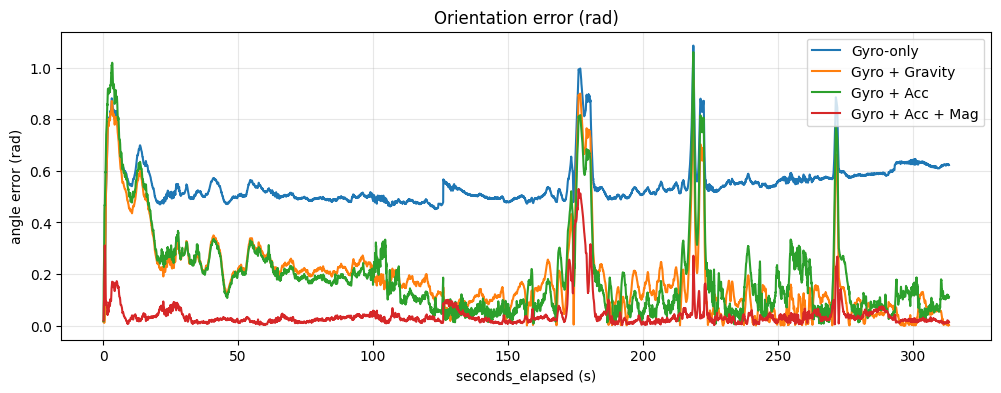

In [6]:
out_gyro_path = out_dir / "01_angle_err_gyro.csv"
out_grav_path = out_dir / "02_angle_err_gyro_grav.csv"
out_acc_path = out_dir / "03_angle_err_gyro_acc.csv"
out_mag_path = out_dir / "04_angle_err_gyro_acc_mag.csv"

plot_err_from_csv([
        ("Gyro-only", out_gyro_path),
        ("Gyro + Gravity", out_grav_path),
        ("Gyro + Acc", out_acc_path),
        ("Gyro + Acc + Mag", out_mag_path)
])